# Aplicação de métodos de aprendizado de máquina na detecção de câncer de mama
### Instalação de bibliotecas

In [33]:
# pip install ucimlrepo -q

### Importação de bibliotecas

In [34]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import joblib

### Carregamento de dados

In [36]:
# buscando dataset 
breast_cancer_coimbra = fetch_ucirepo(id=451) 

In [37]:
# separando em variáveis preditoras (features) e alvo (target)
X = breast_cancer_coimbra.data.features.copy()
y = breast_cancer_coimbra.data.targets.copy()

In [38]:
# ajuste dos valores do target
y = y.replace({1: 0, 2: 1})

In [39]:
print("Dados carregados com sucesso. Shape de X:", X.shape)
print("Distribuição da variável alvo (y):")

y.value_counts()

Dados carregados com sucesso. Shape de X: (116, 9)
Distribuição da variável alvo (y):


Classification
1                 64
0                 52
Name: count, dtype: int64

In [40]:
X.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920


In [41]:
y.head()

,Classification
0,0
1,0
2,0
3,0
4,0


### Exploração de dados

In [42]:
# metadados do dataset
print(breast_cancer_coimbra.metadata) 

{'uci_id': 451, 'name': 'Breast Cancer Coimbra', 'repository_url': 'https://archive.ics.uci.edu/dataset/451/breast+cancer+coimbra', 'data_url': 'https://archive.ics.uci.edu/static/public/451/data.csv', 'abstract': 'Clinical features were observed or measured for 64 patients with breast cancer and 52 healthy controls. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 116, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': ['Age'], 'target_col': ['Classification'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C52P59', 'creators': ['Miguel Patrcio', 'Jos Pereira', 'Joana Crisstomo', 'Paulo Matafome', 'Raquel Seia', 'Francisco Caramelo'], 'intro_paper': {'ID': 431, 'type': 'NATIVE', 'title': 'Using Resistin, glucose, age and BMI to predict the presence of breast cancer', 'authors': 'M.

In [43]:
# detalhes de cada variável do dataset
breast_cancer_coimbra.variables

,name,role,type,demographic,description,units,missing_values
0,Age,Feature,Integer,Age,None,year,no
1,BMI,Feature,Continuous,None,None,kg/m2,no
2,Glucose,Feature,Integer,None,None,mg/dL,no
3,Insulin,Feature,Continuous,None,None,µU/mL,no
4,HOMA,Feature,Continuous,None,None,None,no
5,Leptin,Feature,Continuous,None,None,ng/mL,no
6,Adiponectin,Feature,Continuous,None,None,µU/mL,no
7,Resistin,Feature,Continuous,None,None,ng/mL,no
8,MCP.1,Feature,Continuous,None,None,pg/dL,no
9,Classification,Target,Integer,None,"1=Healthy controls, 2=Patients",None,no


In [44]:
# Estatísticas Descritivas 
X.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474283,6.881763,269.978250
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000


In [45]:
# Contagem de Valores Ausentes
print(X.isnull().sum().to_frame(name='Missing Count'))

             Missing Count
Age                      0
BMI                      0
Glucose                  0
Insulin                  0
HOMA                     0
Leptin                   0
Adiponectin              0
Resistin                 0
MCP.1                    0


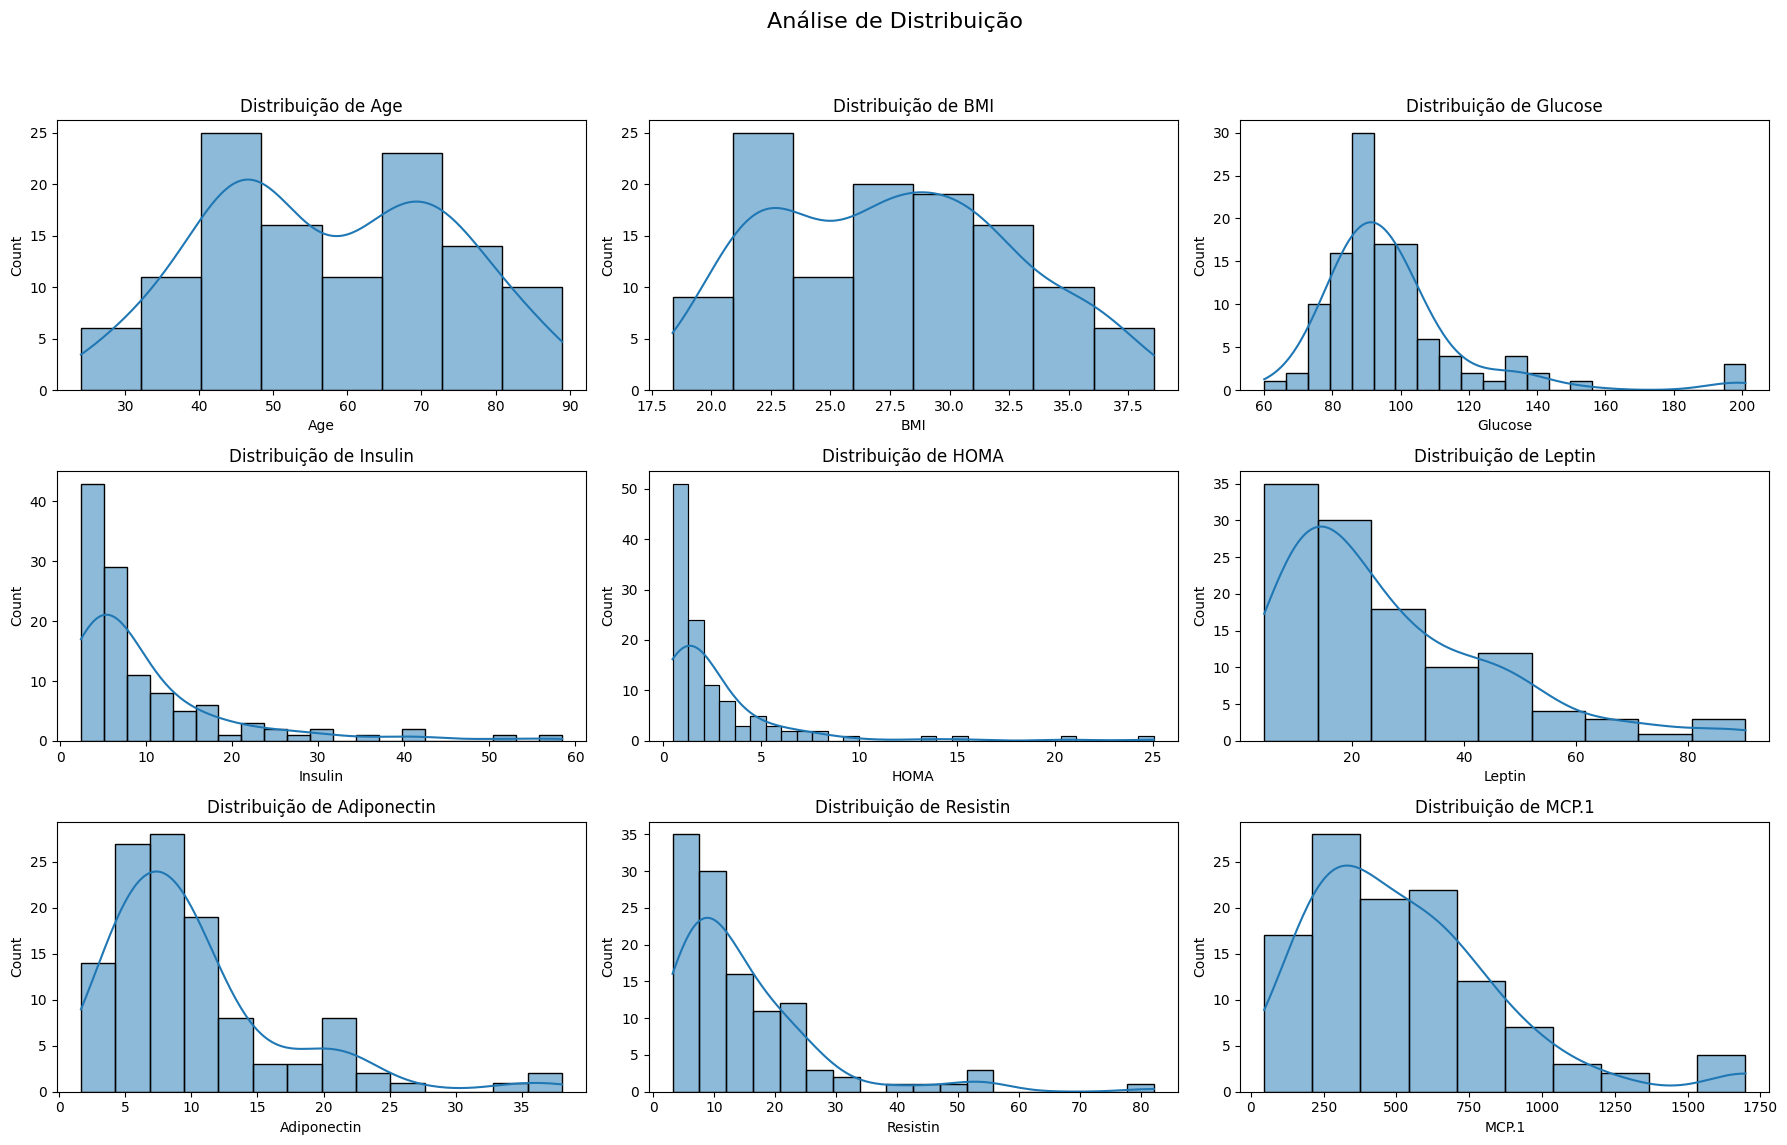

In [46]:
plt.figure(figsize=(18, 12))
plt.suptitle('Análise de Distribuição', fontsize=16)

# Histogramas para distribuição
for i, col in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribuição de {col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

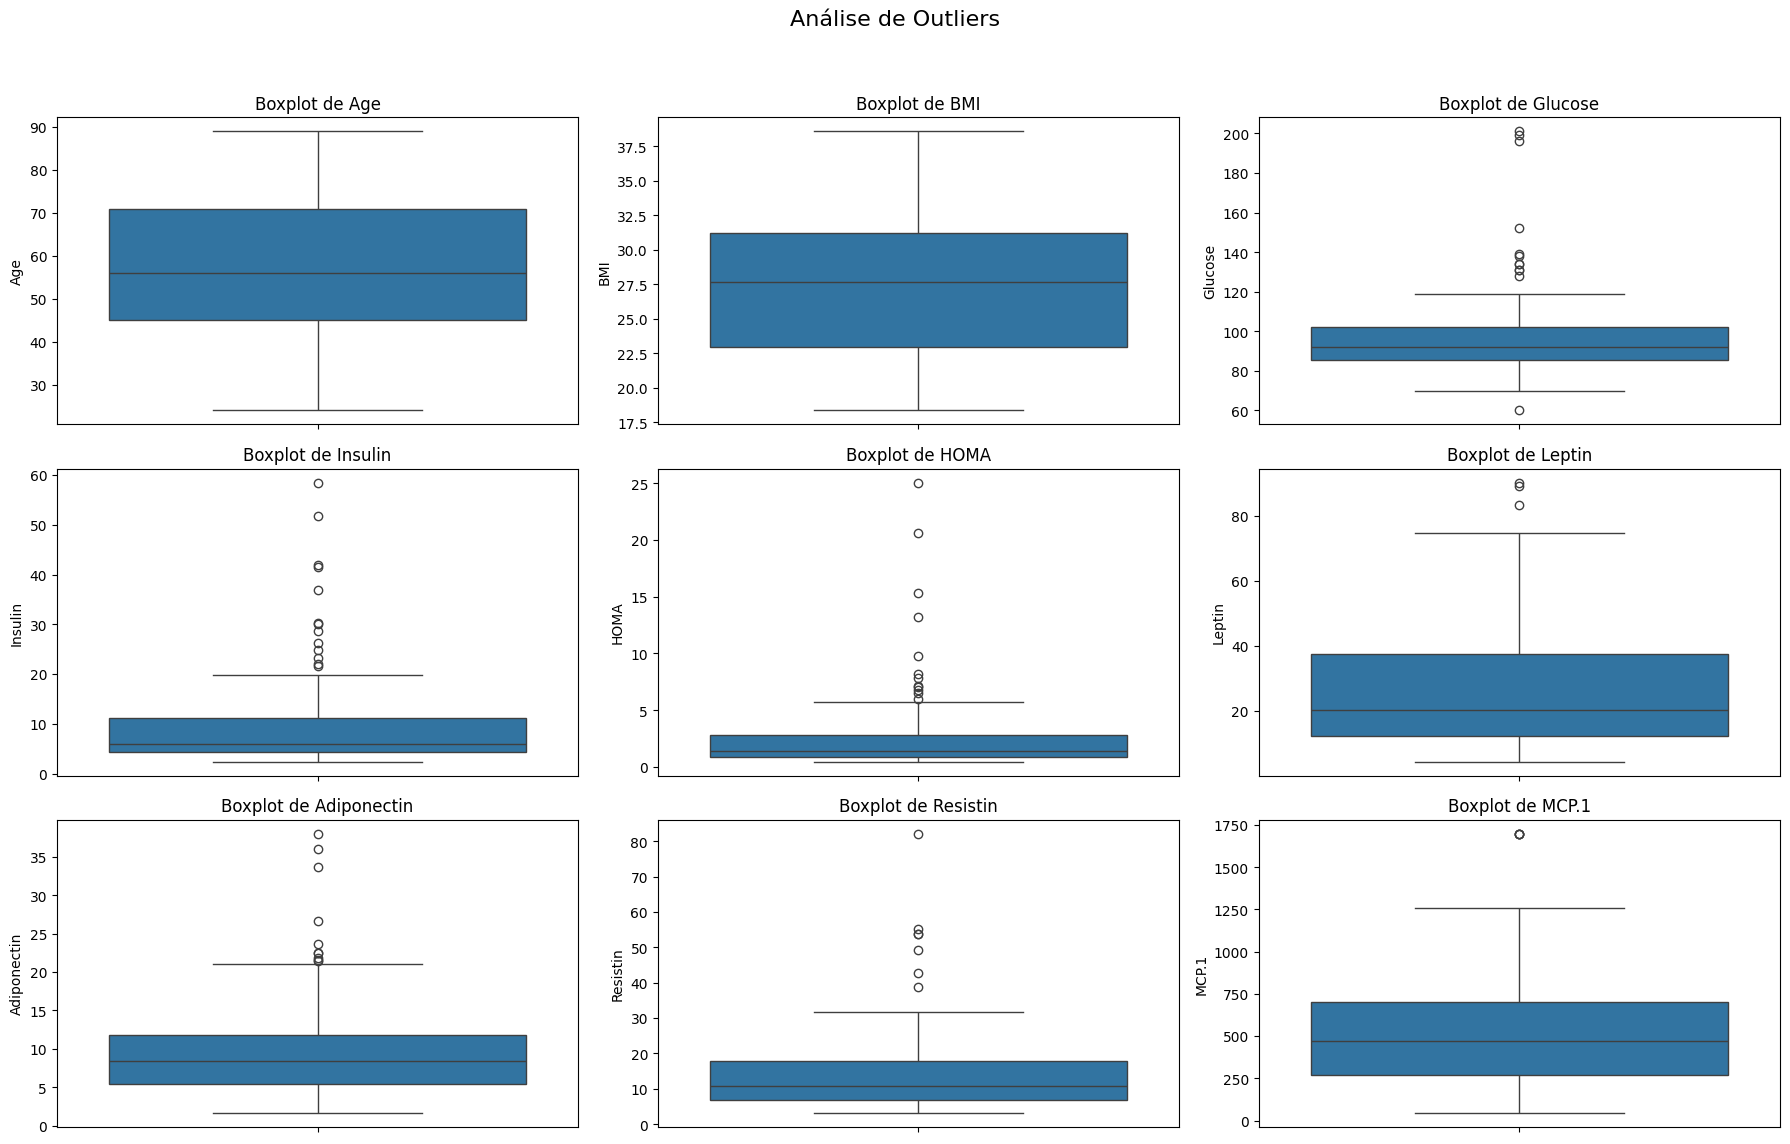

In [47]:
# Boxplots para Outliers
plt.figure(figsize=(18, 12))
plt.suptitle('Análise de Outliers', fontsize=16)
for i, col in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=X[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

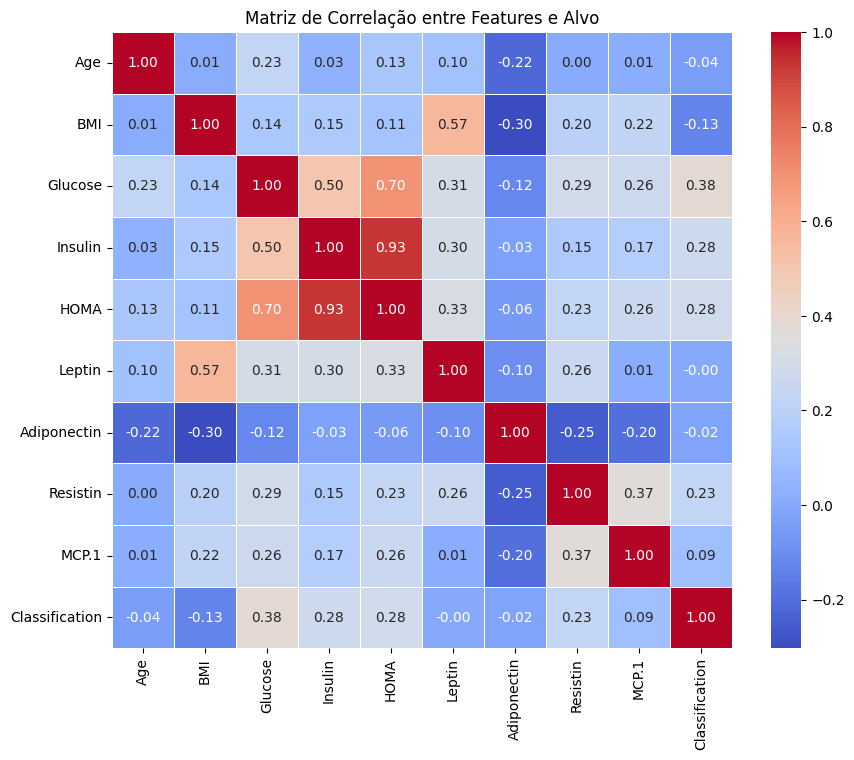

In [48]:
# Análise de Correlação
plt.figure(figsize=(10, 8))
data = pd.concat([X, y], axis=1)
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlação entre Features e Alvo')
plt.show()

### Divisão treino e teste

In [49]:
# Divisão dos dados em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y.values.ravel(), 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"Dados Divididos. X_train: {X_train.shape}, X_test: {X_test.shape}")

Dados Divididos. X_train: (92, 9), X_test: (24, 9)


### Escalonamento de variáveis numéricas

#### StandardScaler (Padronização)

In [50]:
scaler_standard = StandardScaler()
X_standard = pd.DataFrame(scaler_standard.fit_transform(X_train), columns=X_train.columns)

#### MinMaxScaler (Normalização)

In [51]:
scaler_minmax = MinMaxScaler()
X_minmax = pd.DataFrame(scaler_minmax.fit_transform(X_train), columns=X_train.columns)

#### Comparação de Escalonamento

In [52]:
print("StandardScaler:")
X_standard.head(3)

StandardScaler:


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,0.416863,0.363373,-0.604432,0.564394,0.164223,0.007994,-0.429698,0.420985,3.367421
1,1.476983,-0.914196,-0.331622,-0.614514,-0.532530,-0.439000,1.653546,-0.420331,0.037256
2,-0.643257,0.909282,0.032124,2.193565,1.492845,1.027307,1.535003,-0.347639,0.571066


In [53]:
print("MinMaxScaler:")
X_minmax.head(3)

MinMaxScaler:


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,0.630769,0.558993,0.177305,0.309589,0.129145,0.256923,0.141958,0.206024,1.000000
1,0.892308,0.235278,0.219858,0.052354,0.026893,0.156967,0.564580,0.076906,0.307912
2,0.369231,0.697317,0.276596,0.665070,0.324129,0.484862,0.540531,0.088063,0.418850


In [54]:
print("Min/Max após StandardScaler:", float(np.min(X_standard)), float(np.max(X_standard)))

Min/Max após StandardScaler: -2.1398974019839043 6.098246599123587


In [55]:
print("Min/Max após MinMaxScaler:", float(np.min(X_minmax)), float(np.max(X_minmax)))

Min/Max após MinMaxScaler: 0.0 1.0


### Decisão: 

Optamos por continuar com o StandardScaler, pois:
- Manteve o contraste dos valores, não esmagando outliers como o MinMax (o valor 6.09 sugeriu a presença de um valor extremo)
- Melhorou a separabilidade estatística nas features que possuem escalas muito diferentes, como: idade, glicose e HOMA

### Balanceamento dos dados 

#### Sem Balanceamento (Baseline)

In [56]:
print("Distribuição no Treino (Desbalanceada):\n")
print(pd.Series(y_train).value_counts(normalize=True))

model_unbalanced = LogisticRegression(random_state=42, max_iter=1000)
model_unbalanced.fit(X_train, y_train)
y_pred_unbalanced = model_unbalanced.predict(X_test)

print("\nRelatório de Classificação SEM Balanceamento:")
print(classification_report(y_test, y_pred_unbalanced, zero_division=0))

Distribuição no Treino (Desbalanceada):

1    0.554348
0    0.445652
Name: proportion, dtype: float64

Relatório de Classificação SEM Balanceamento:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.82      0.69      0.75        13

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



#### Balanceamento com SMOTE (Oversampling)

In [57]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Resultados com Balanceamento (SMOTE)")
print("Distribuição após SMOTE:\n")
print(pd.Series(y_smote).value_counts(normalize=True))

model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_smote, y_smote)
y_pred_smote = model_smote.predict(X_test)

print("\nRelatório de Classificação COM SMOTE:")
print(classification_report(y_test, y_pred_smote, zero_division=0))

Resultados com Balanceamento (SMOTE)
Distribuição após SMOTE:

1    0.5
0    0.5
Name: proportion, dtype: float64

Relatório de Classificação COM SMOTE:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.82      0.69      0.75        13

    accuracy                           0.75        24
   macro avg       0.76      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



#### Balanceamento com Tomek Links (Undersampling)


In [58]:
tl = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tl.fit_resample(X_train, y_train)

print("Resultados COM Balanceamento (Tomek Links)")
print("Distribuição após Tomek Links:\n")
print(pd.Series(y_tomek).value_counts(normalize=True))

model_tomek = LogisticRegression(random_state=42, max_iter=1000)
model_tomek.fit(X_tomek, y_tomek)
y_pred_tomek = model_tomek.predict(X_test)

print("\nRelatório de Classificação COM Tomek Links:")
print(classification_report(y_test, y_pred_tomek, zero_division=0))

Resultados COM Balanceamento (Tomek Links)
Distribuição após Tomek Links:

0    0.506173
1    0.493827
Name: proportion, dtype: float64

Relatório de Classificação COM Tomek Links:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.80      0.62      0.70        13

    accuracy                           0.71        24
   macro avg       0.72      0.72      0.71        24
weighted avg       0.73      0.71      0.71        24



### Decisão:
Optamos por não utilizar nenhuma estratégia de balanceamento devido ao tamanho do dataset ser pequeno. O SMOTE e o TOMEK pioraram as métricas por falta de densidade suficiente de dados.


### Determinando as features mais relevantes (Feature Selection)

#### Regressão Logística (Análise de Coeficientes)
Mede a influência linear direta de cada variável sobre o desfecho. O coeficiente indica quanto a probabilidade do evento muda quando a feature aumenta. Quanto maior a magnitude (valor absoluto), maior o impacto daquela variável na decisão do modelo. Método usado para entender relações lineares
- Utilizando as features escalonadas

Importância das Features (Regressão Logística)
       Feature  Coeficiente  Importância Absoluta
2      Glucose     1.835561              1.835561
7     Resistin     0.580698              0.580698
5       Leptin    -0.480801              0.480801
1          BMI    -0.405613              0.405613
4         HOMA     0.321723              0.321723
3      Insulin     0.313226              0.313226
0          Age    -0.241940              0.241940
6  Adiponectin    -0.031160              0.031160
8        MCP.1     0.028188              0.028188


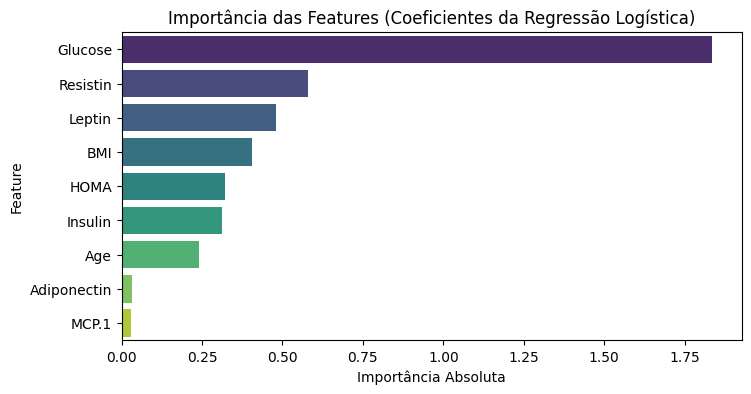

In [59]:
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_standard, y_train)

coef_df = pd.DataFrame({
    'Feature': X_standard.columns,
    'Coeficiente': log_reg_model.coef_[0],
    'Importância Absoluta': np.abs(log_reg_model.coef_[0])
}).sort_values(by='Importância Absoluta', ascending=False)

print("Importância das Features (Regressão Logística)")
print(coef_df)

plt.figure(figsize=(8, 4))
sns.barplot(
    x='Importância Absoluta', 
    y='Feature', 
    hue='Feature',
    data=coef_df, 
    palette='viridis',
    legend=False )
plt.title('Importância das Features (Coeficientes da Regressão Logística)')
plt.show()

#### Importância da Árvore (Random Forest Classifier)
Avalia a importância de cada feature observando quanto ela reduz a impureza ao dividir os dados nas árvores. Esse método captura relações não lineares e interações entre variáveis que a regressão logística não enxerga. Quanto mais uma feature melhora a capacidade das árvores de separar as classes, mais importante ela é considerada
- Não utilizando as features escalonadas

Importância das Features (Random Forest)
       Feature  Importância RF
2      Glucose        0.243951
7     Resistin        0.138093
1          BMI        0.108699
0          Age        0.103607
5       Leptin        0.092914
3      Insulin        0.092001
4         HOMA        0.089045
8        MCP.1        0.072786
6  Adiponectin        0.058904


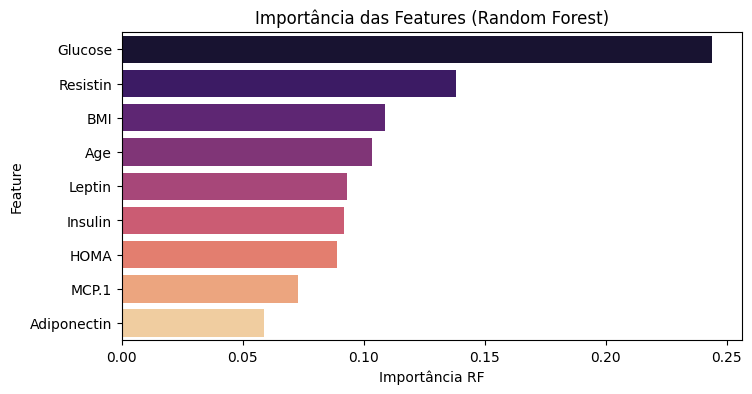

In [60]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importance_rf_df = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importância RF': feature_importances.values
}).sort_values(by='Importância RF', ascending=False)

print("Importância das Features (Random Forest)")
print(importance_rf_df)

plt.figure(figsize=(8, 4))
sns.barplot(
    x='Importância RF',
    y='Feature', 
    hue='Feature',
    data=importance_rf_df, 
    palette='magma')
plt.title('Importância das Features (Random Forest)')
plt.show()

#### Análise de Variância / Desvio-Padrão
Mede o quanto uma feature realmente varia na base. Variáveis com pouquíssima variação carregam pouca informação. Já variáveis extremamente voláteis podem indicar ruído. Esse método ajuda a descartar tanto variáveis constantes quanto extremamente ruidosas
- Não utilizando as features escalonadas

Variância e Desvio-Padrão das Features
                 Variância  Desvio-Padrão
MCP.1        119253.670301     345.331247
Glucose         489.022814      22.113860
Leptin          372.257040      19.293964
Age             259.976469      16.123786
Resistin        148.198397      12.173676
Insulin          74.955661       8.657694
Adiponectin      53.461819       7.311759
BMI              26.508334       5.148624
HOMA              8.852451       2.975307


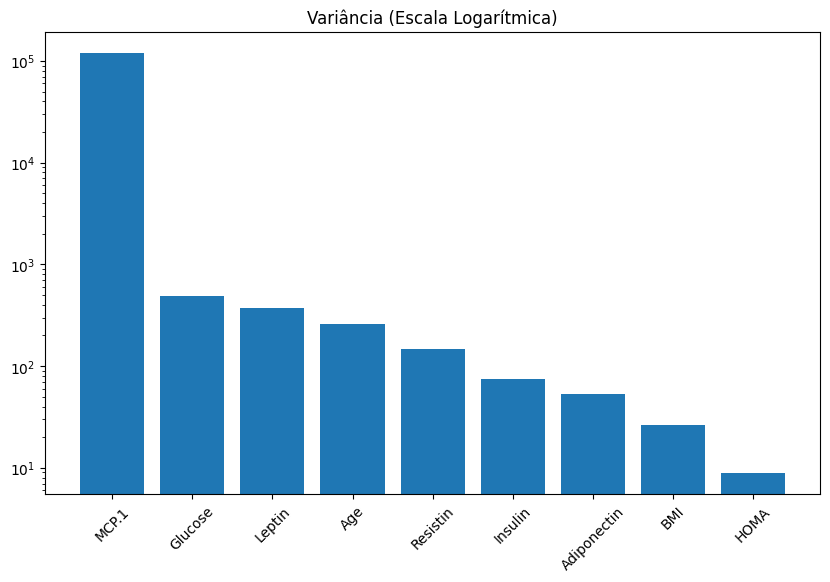

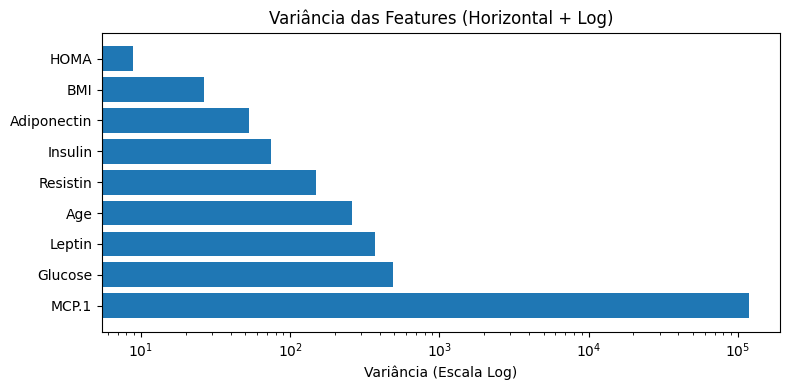

In [61]:
print("Variância e Desvio-Padrão das Features")
variance_std_df = pd.DataFrame({
    'Variância': X_train.var(),
    'Desvio-Padrão': X_train.std()
}).sort_values(by='Variância', ascending=False)

print(variance_std_df)

plt.figure(figsize=(10, 6))
plt.bar(variance_std_df.index, variance_std_df['Variância'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.title("Variância (Escala Logarítmica)")
plt.show()


plt.figure(figsize=(8, 4))
plt.barh(variance_std_df.index, variance_std_df['Variância'])
plt.xscale('log')
plt.xlabel("Variância (Escala Log)")
plt.title("Variância das Features (Horizontal + Log)")
plt.tight_layout()
plt.show()


#### Escolhendo o Conjunto Final de Features

As cinco features escolhidas — Glucose, Resistin, BMI, Leptin e Age — foram selecionadas porque são as únicas que se destacam de forma consistente nos três métodos. A convergência das três perspectivas dos metodos utilizados — linearidade (Regressão Logística), não linearidade (Random Forest) e informatividade estatística (Variância/Desvio Padrão) — torna esse subconjunto o mais adequado para compor o núcleo preditivo dos modelos

In [62]:
# Seleção das top 5 features
selected_features = ['Glucose', 'Resistin', 'BMI', 'Leptin', 'Age']

In [63]:
# Criando o conjunto final de features
X_train_features = X_train[selected_features]
X_test_features = X_test[selected_features]

X_features = X[selected_features]

print(f"Conjunto Final de Features Escolhidas para Modelagem: {selected_features}")
print("Shape do Conjunto Final:", X_train_features.shape)

Conjunto Final de Features Escolhidas para Modelagem: ['Glucose', 'Resistin', 'BMI', 'Leptin', 'Age']
Shape do Conjunto Final: (92, 5)


#### Salvar dados de treino e teste

In [64]:
joblib.dump({
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "X": X,
    "y": y,
    "X_train_features": X_train_features,
    "X_test_features": X_test_features,
    "X_features": X_features
}, "splits/dados_splits.joblib")

['splits/dados_splits.joblib']